In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import fashion_mnist, mnist
import numpy as np
import shap
import json
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

## Ładowanie datasetu

In [2]:
data = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 318s 2us/step


In [3]:
train_data, test_data = data
X_train, y_train = train_data
X_test, y_test = test_data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [4]:
class_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

## Konfiguracja modelu sieci

In [5]:
base = VGG16(weights='imagenet', input_shape=(32, 32, 3), include_top=False)
x = layers.Flatten()(base.output)
x = layers.Dense(256, activation='relu')(x)
out = layers.Dense(10, activation='softmax')(x)

model = keras.Model(base.input, out)
model.summary()

58892288/58889256 [==============================] - 110s 2us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
____________________________________________________________

## Ładowanie wag modelu

In [6]:
model.load_weights('cifar_weights_vgg_16.h5')

In [16]:
np.argmax(model.predict(X_train[:5]), axis=-1)

array([6, 9, 9, 4, 1])

## Selekcja przykładowych próbek

In [82]:
SAMPLES_CLASS = 4
TEST_SAMPLES_COUNT = 10

class_indices = np.argwhere((y_test == SAMPLES_CLASS).flatten()).flatten()
indices_to_explain = np.random.choice(class_indices, TEST_SAMPLES_COUNT, replace=False)
images_to_explain = X_test[indices_to_explain] / 255

## Wyjaśnienie próbek za pomocą DeepExplainer'a

In [83]:
%%time
background = np.zeros((1, 32, 32, 3))
# background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(images_to_explain)
np_shap = np.array(shap_values)

CPU times: user 1min 33s, sys: 2min 12s, total: 3min 46s
Wall time: 55.1 s


## Znalezienie najciekawszych próbek

Spośród wybranych losowo próbek znajdujemy te, których klasyfikacja była trudna dla modelu oraz te, które posiadają bardzo wysokie i/lub niskie wartości Shapley'a.

In [84]:
model.predict(images_to_explain * 255).round(2)

array([[0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.99, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.05, 0.  , 0.95, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

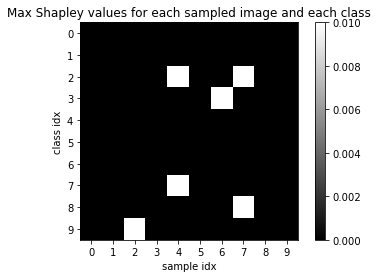

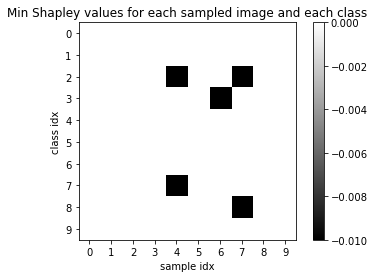

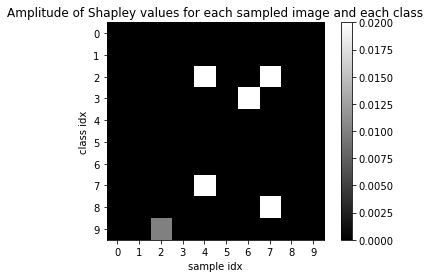

In [85]:
maxes = np_shap.reshape((*np_shap.shape[:2], -1)).max(axis=-1).round(2)
mins = np_shap.reshape((*np_shap.shape[:2], -1)).min(axis=-1).round(2)
amplitude = maxes - mins

def plot_stuff(array, title):
    plt.imshow(array, cmap='gray')
    plt.colorbar()
    plt.xticks(range(TEST_SAMPLES_COUNT))
    plt.xlabel('sample idx')
    plt.yticks(range(len(class_names)))
    plt.ylabel('class idx')
    plt.title(title)
    plt.show()

plot_stuff(maxes, 'Max Shapley values for each sampled image and each class')
plot_stuff(mins, 'Min Shapley values for each sampled image and each class')
plot_stuff(amplitude, 'Amplitude of Shapley values for each sampled image and each class')

## Demonstracja znalezionych wartości Shapley'a dla wybranych próbek

In [86]:
def plot_shap_values(shap_values, classes_indices_to_explain, samples_to_plot, images, class_names):
    np_shap = np.array(shap_values)
    labels = np.array([[f'Explained class {class_names[idx]}' for idx in classes_indices_to_explain]])
    for sample_idx in samples_to_plot:
        print(f'Explained Shapley values for sample {sample_idx}')
        shap_plot_input = list(np_shap[classes_indices_to_explain][:, [sample_idx]])
        shap.image_plot(shap_plot_input, images[[sample_idx]], labels)

Explained Shapley values for sample 6


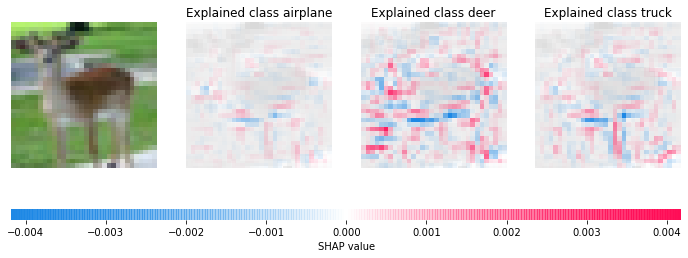

In [87]:
plot_shap_values(shap_values=shap_values,
                 classes_indices_to_explain=[0, 4, 9], 
                 samples_to_plot=[6], 
                 images=images_to_explain,
                 class_names=class_names)

Explained Shapley values for sample 0


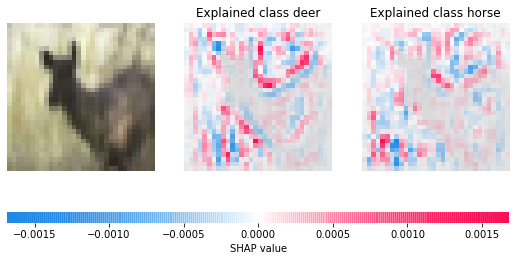

Explained Shapley values for sample 1


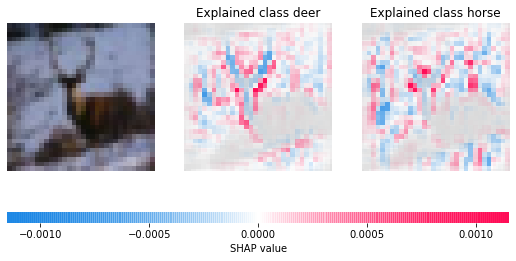

Explained Shapley values for sample 2


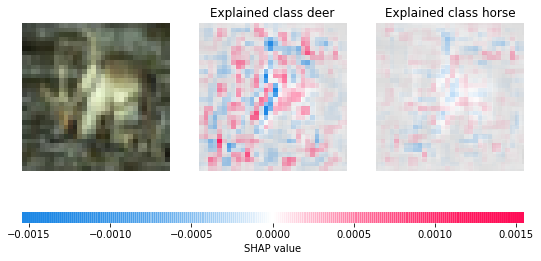

Explained Shapley values for sample 3


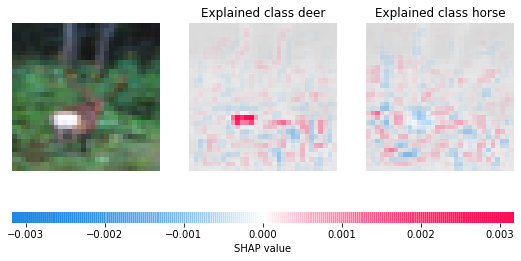

In [88]:
plot_shap_values(shap_values=shap_values,
                 classes_indices_to_explain=[4, 7], 
                 samples_to_plot=[0, 1, 2, 3], 
                 images=images_to_explain,
                 class_names=class_names)

## Aplikacja rozmycia gaussowskiego na znalezionych wartościach Shapley'a

W celu nieco bardziej intuicyjnej prezentacji działania Shap values aplikujemy na znalezione wartości rozmycie gaussowskie pozwalające łatwiej zauważyć, które części obrazu wpływają na predykcję

In [89]:
def blur_shap_values(shap_values, gaussian_blur_sigma):
    classes_count = len(shap_values)
    samples_count = shap_values[0].shape[0]
    
    blurred_shap_values = []
    for class_idx in range(classes_count):
        blurred = []
        for sample_idx in range(samples_count):
            blurred.append(gaussian_filter(shap_values[class_idx][sample_idx], sigma=gaussian_blur_sigma))
        blurred_shap_values.append(blurred)
    return blurred_shap_values

In [90]:
blurred_shap_values = blur_shap_values(shap_values, 1)

Explained Shapley values for sample 7


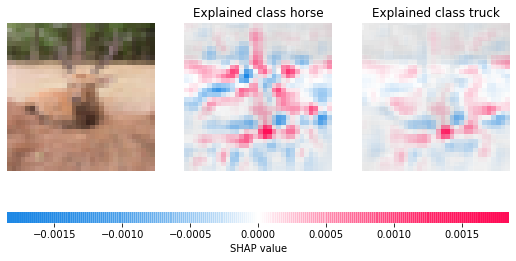

In [91]:
plot_shap_values(shap_values=blurred_shap_values,
                 classes_indices_to_explain=[7, 9], 
                 samples_to_plot=[7], 
                 images=images_to_explain,
                 class_names=class_names)

## Analiza próbek błędnie sklasyfikowanych

Przeanalizuj błędnie sklasyfikowane próbki za pomocą DeepExplainera analogicznie do pokazanych wyżej przykładów.

In [92]:
pred = np.argmax(model.predict(X_test), axis=-1)
pred

array([5, 8, 8, ..., 5, 0, 7])

In [95]:
y_test = y_test.flatten()
np.mean(pred == y_test)

0.839

In [99]:
incorrect_indices = pred != y_test
samples = X_test[incorrect_indices] / 255
true_labels = y_test[incorrect_indices]
pred_labels = pred[incorrect_indices]

In [100]:
X_train.shape

(50000, 32, 32, 3)

In [101]:
np.mean(X_train, axis=0)[np.newaxis, :].shape

(1, 32, 32, 3)

In [102]:
%%time

SAMPLES_TO_VISUALIZE = 15

samples = samples[:SAMPLES_TO_VISUALIZE]
true_labels = true_labels[:SAMPLES_TO_VISUALIZE]
pred_labels = pred_labels[:SAMPLES_TO_VISUALIZE]

background = np.zeros((1, 32, 32, 3))
# background = np.mean(X_train, axis=0)[np.newaxis, :]
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(samples)

CPU times: user 2min, sys: 2min 27s, total: 4min 27s
Wall time: 1min 2s


Explained Shapley values for sample 0


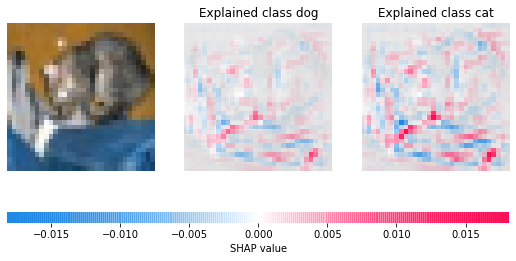

Explained Shapley values for sample 1


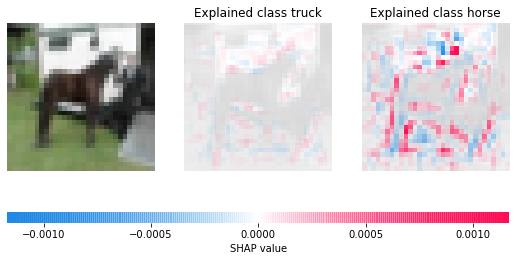

Explained Shapley values for sample 2


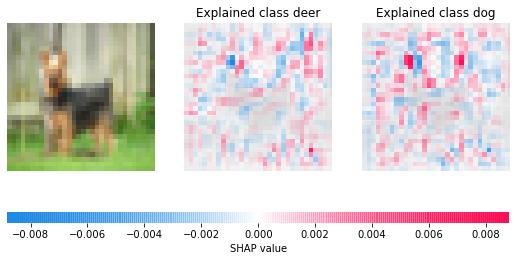

Explained Shapley values for sample 3


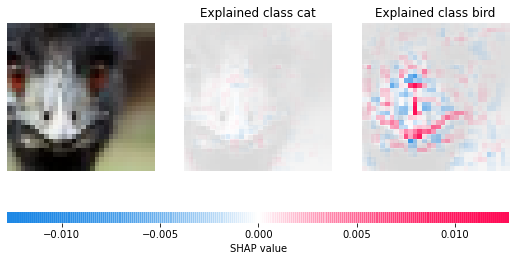

Explained Shapley values for sample 4


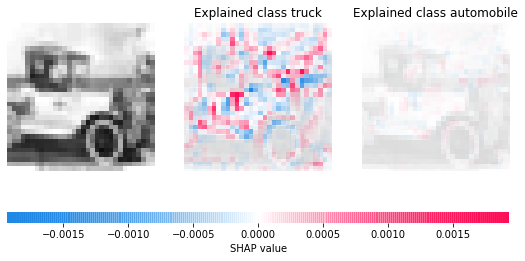

Explained Shapley values for sample 5


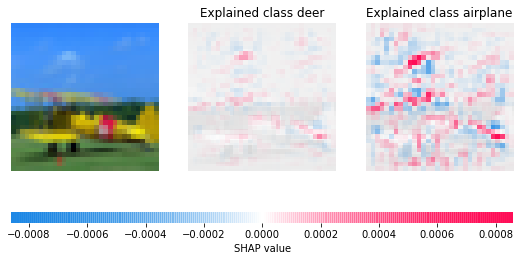

Explained Shapley values for sample 6


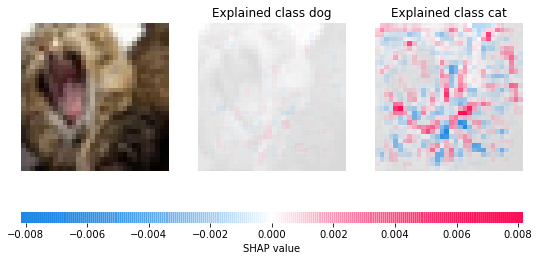

Explained Shapley values for sample 7


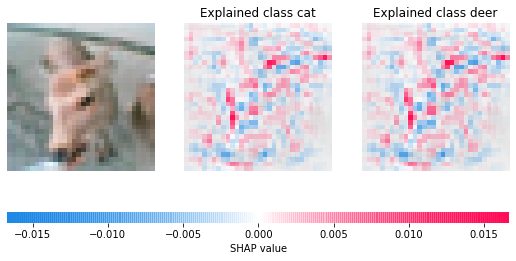

Explained Shapley values for sample 8


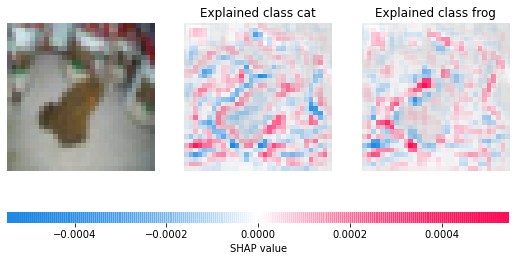

Explained Shapley values for sample 9


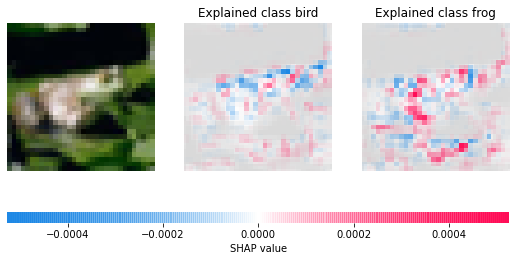

Explained Shapley values for sample 10


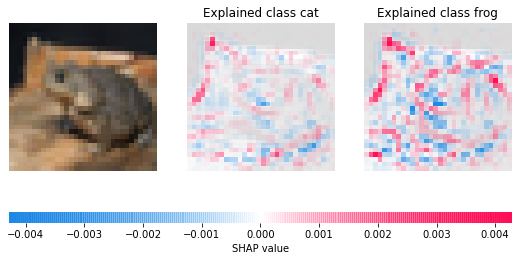

Explained Shapley values for sample 11


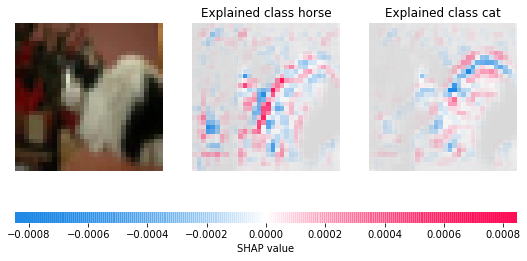

Explained Shapley values for sample 12


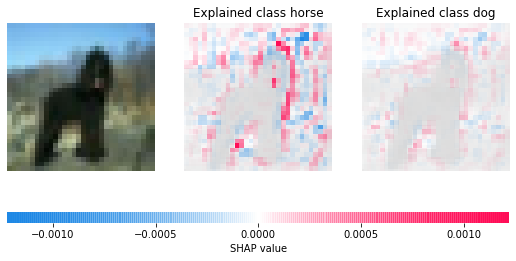

Explained Shapley values for sample 13


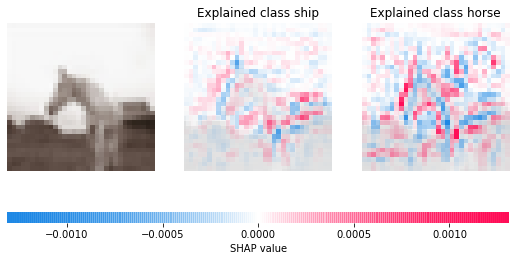

Explained Shapley values for sample 14


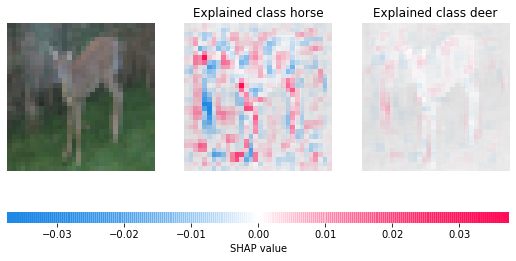

In [103]:
for i in range(SAMPLES_TO_VISUALIZE):
    plot_shap_values(shap_values=shap_values,
                     classes_indices_to_explain=[pred_labels[i], true_labels[i]], 
                     samples_to_plot=[i], 
                     images=samples,
                     class_names=class_names)

Explained Shapley values for sample 0


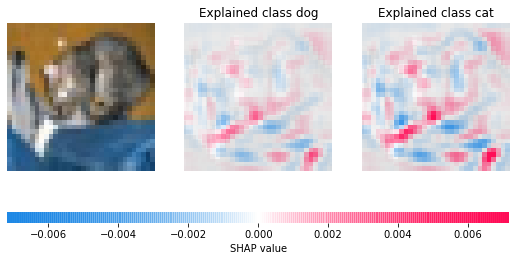

Explained Shapley values for sample 1


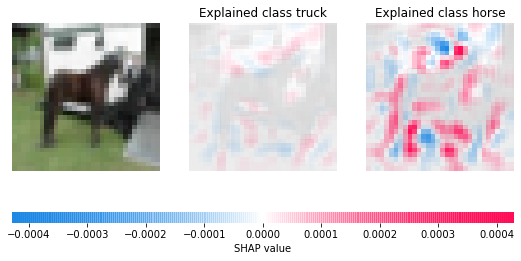

Explained Shapley values for sample 2


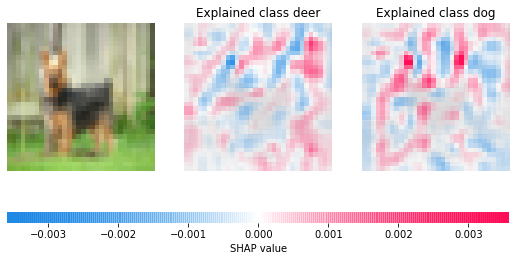

Explained Shapley values for sample 3


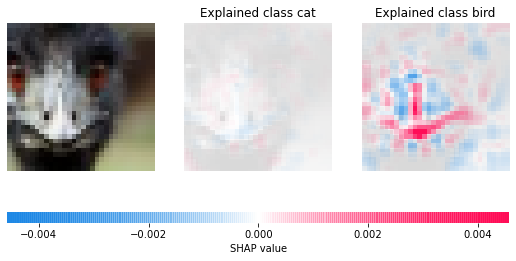

Explained Shapley values for sample 4


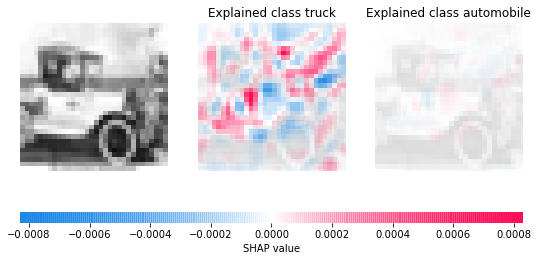

Explained Shapley values for sample 5


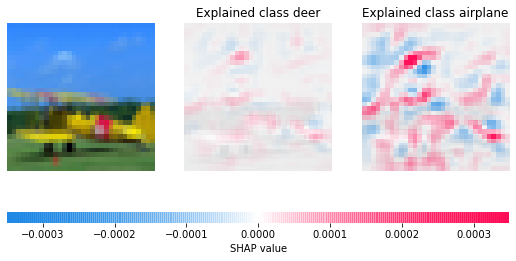

Explained Shapley values for sample 6


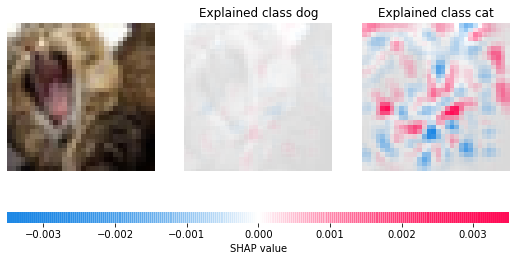

Explained Shapley values for sample 7


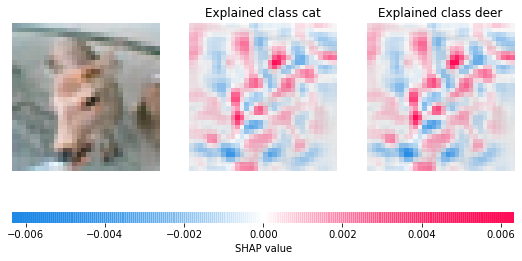

Explained Shapley values for sample 8


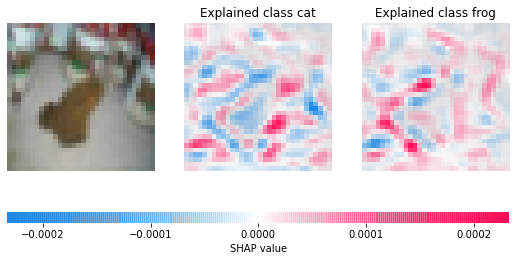

Explained Shapley values for sample 9


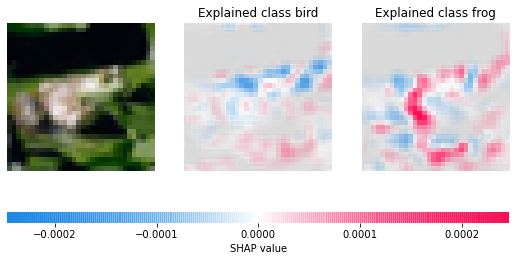

Explained Shapley values for sample 10


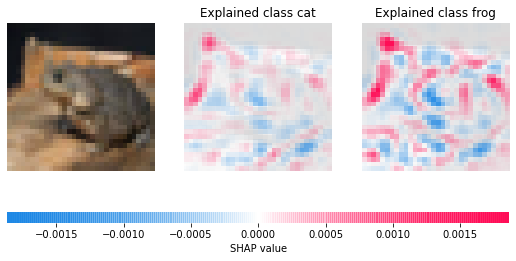

Explained Shapley values for sample 11


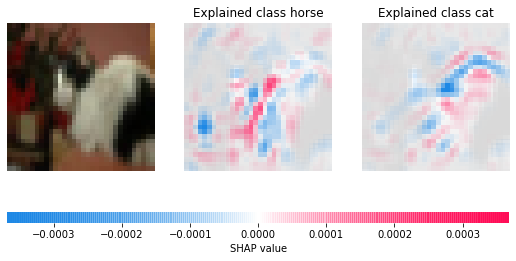

Explained Shapley values for sample 12


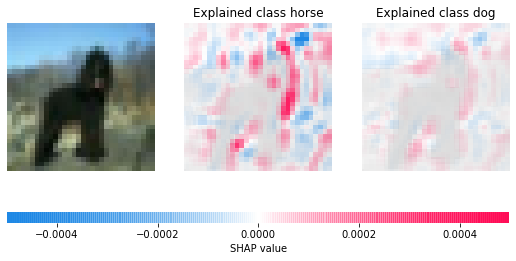

Explained Shapley values for sample 13


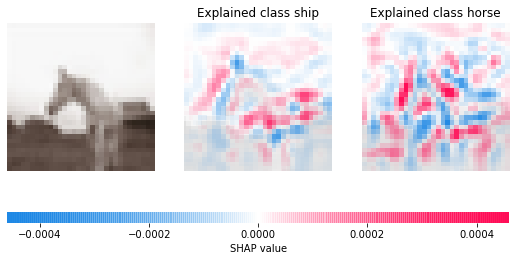

Explained Shapley values for sample 14


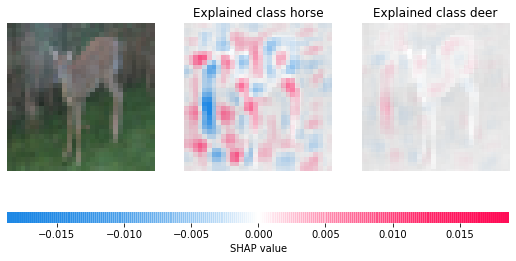

In [104]:
blurred_shap_values = blur_shap_values(shap_values, 1)
for i in range(SAMPLES_TO_VISUALIZE):
    plot_shap_values(shap_values=blurred_shap_values,
                     classes_indices_to_explain=[pred_labels[i], true_labels[i]], 
                     samples_to_plot=[i], 
                     images=samples,
                     class_names=class_names)

## KernelExplainer

In [105]:
def predict_wrapper(model):
    def wrapped(flat_input):
        return model.predict(flat_input.reshape(-1, 32, 32, 3))
    
    return wrapped

In [106]:
np.mean(X_train, axis=0).reshape(1, -1).shape

(1, 3072)

In [110]:
%%time
background = np.zeros((1, 32, 32, 3)).reshape(1, -1)
explainer = shap.KernelExplainer(predict_wrapper(model), background)
shap_values = explainer.shap_values(images_to_explain.reshape(-1, 32 * 32 * 3))

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_


CPU times: user 1h 54min 25s, sys: 24min 42s, total: 2h 19min 8s
Wall time: 35min 7s


In [113]:
shhh = np.array(shap_values).reshape((10, TEST_SAMPLES_COUNT, 32, 32, 3))

Explained Shapley values for sample 0


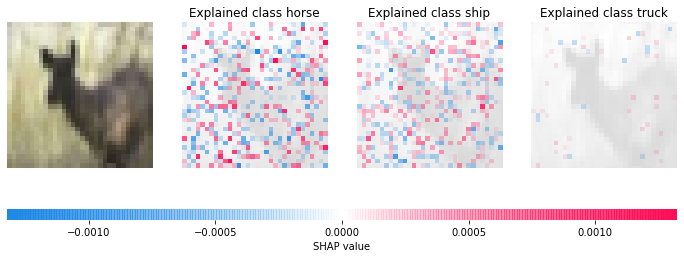

Explained Shapley values for sample 1


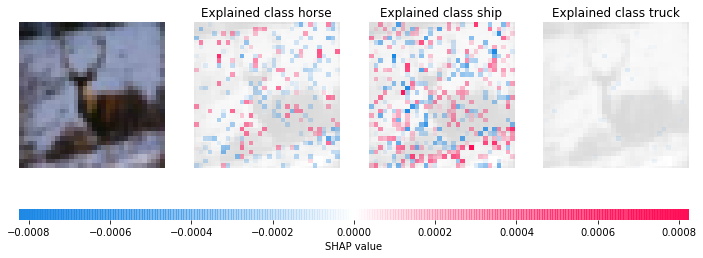

Explained Shapley values for sample 2


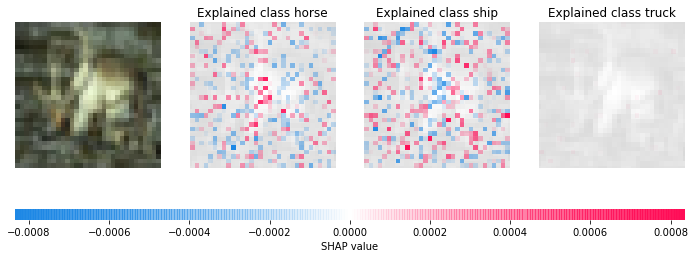

Explained Shapley values for sample 3


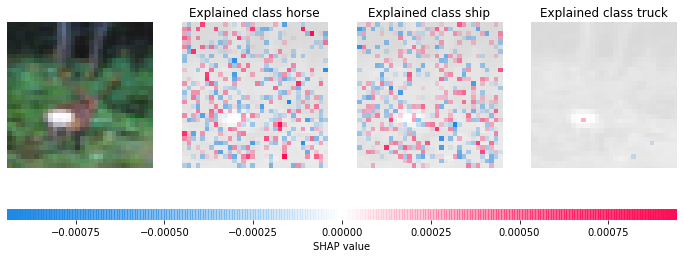

Explained Shapley values for sample 4


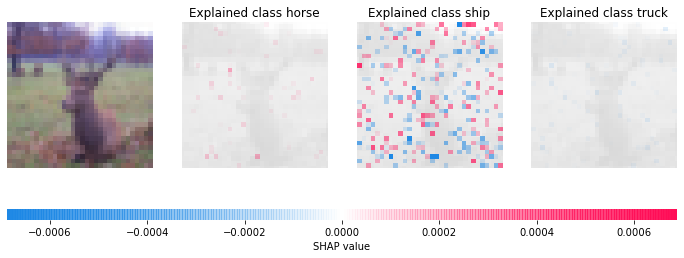

Explained Shapley values for sample 5


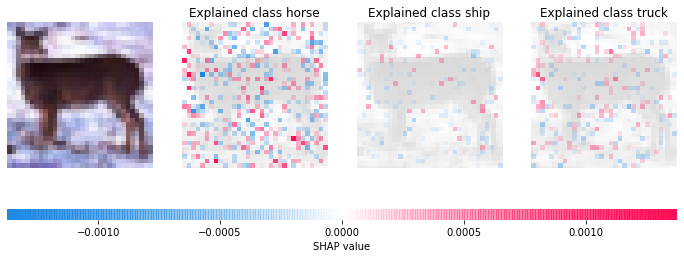

Explained Shapley values for sample 6


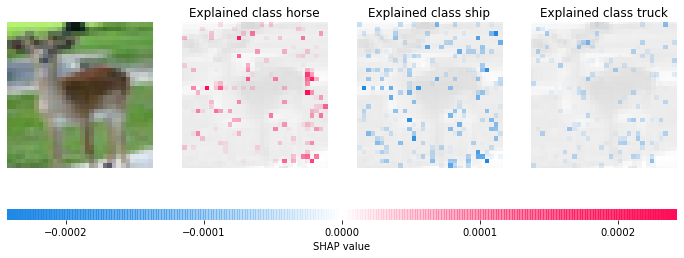

Explained Shapley values for sample 7


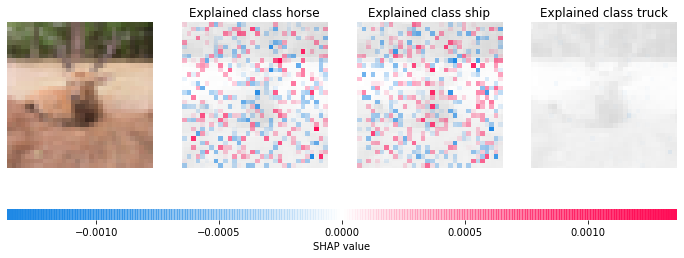

In [114]:
plot_shap_values(shap_values=list(shhh),
                 classes_indices_to_explain=[7, 8, 9], 
                 samples_to_plot=range(8), 
                 images=images_to_explain,
                 class_names=class_names)

Explained Shapley values for sample 0


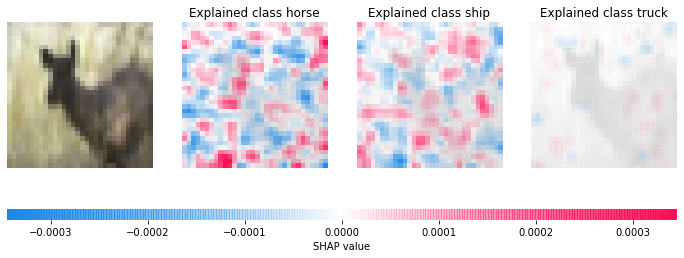

Explained Shapley values for sample 1


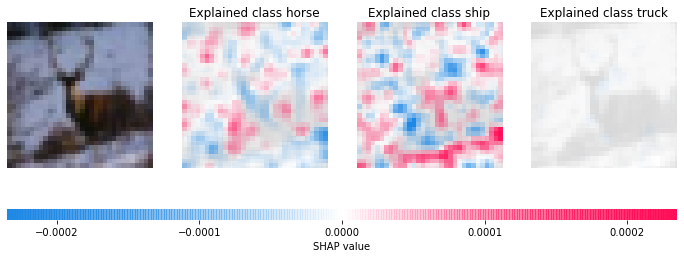

Explained Shapley values for sample 2


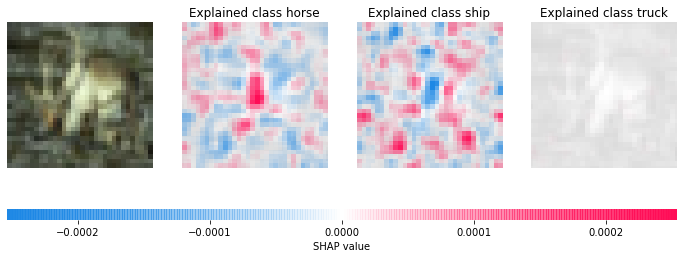

Explained Shapley values for sample 3


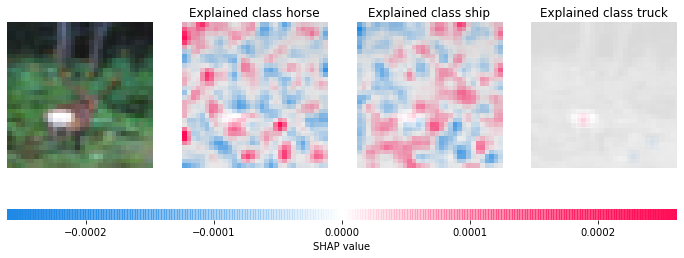

Explained Shapley values for sample 4


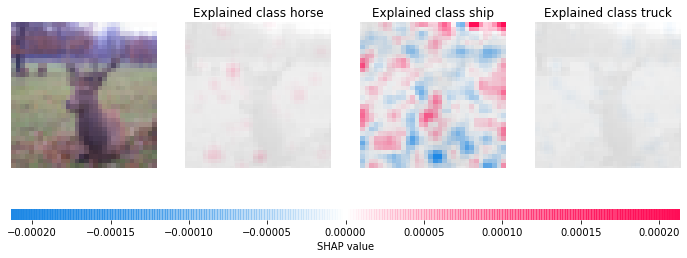

Explained Shapley values for sample 5


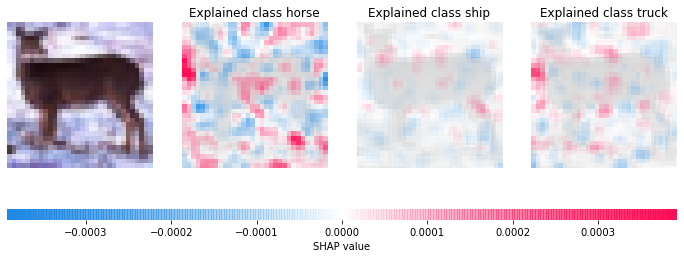

Explained Shapley values for sample 6


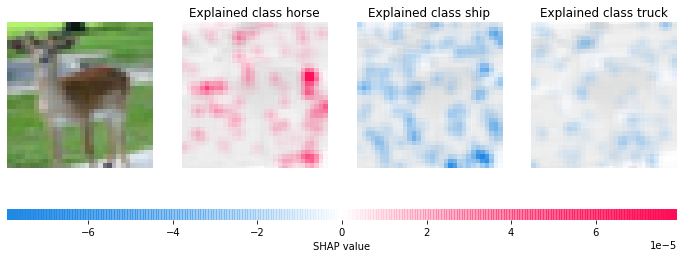

Explained Shapley values for sample 7


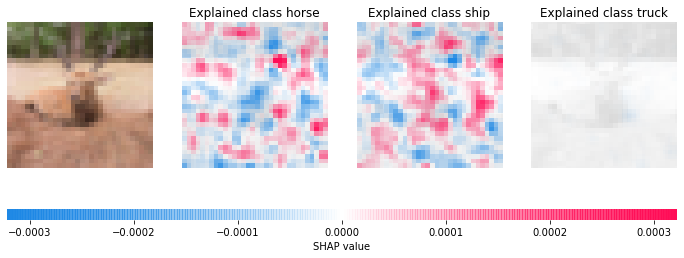

In [115]:
blurred_shhh = blur_shap_values(shhh, 1)
plot_shap_values(shap_values=list(blurred_shhh),
                 classes_indices_to_explain=[7, 8, 9], 
                 samples_to_plot=range(8), 
                 images=images_to_explain,
                 class_names=class_names)